In [1]:
import datetime
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\11494\Downloads\electric_consumption_till_25jun.csv")

In [3]:
df = df[['Date', 'Consumption']]
df.columns = ['date', 'y']
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [4]:
df.head()

,date,y
22200,2017-12-11 00:00:00,56.0
22199,2017-12-11 01:00:00,56.0
22198,2017-12-11 02:00:00,55.0
22197,2017-12-11 03:00:00,52.0
22196,2017-12-11 04:00:00,46.0


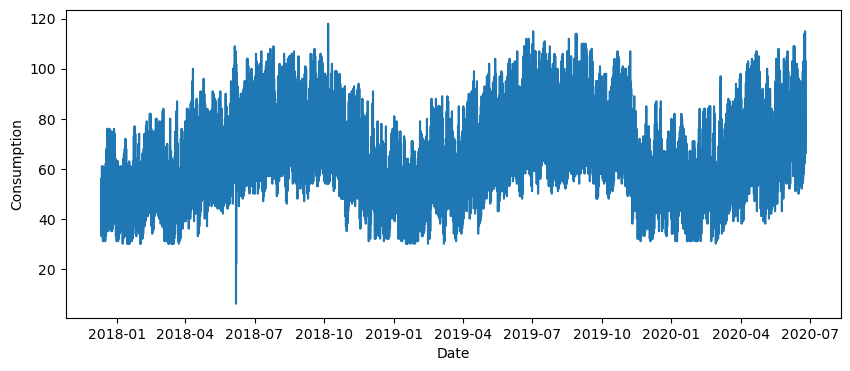

In [5]:
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['y'])
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.show()

# 创建时间特征

In [6]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_week'] = df.date.dt.day_of_week + 1
df['year'] = df.date.dt.year
df['quarter'] = df.date.dt.quarter
df['hour_of_day'] = df.date.dt.hour
df['weekday'] = df.date.dt.weekday
df['is_year_start'] = df.date.dt.is_year_start.astype(int)
df['is_year_end'] = df.date.dt.is_year_end.astype(int)
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)

C:\Users\11494\AppData\Local\Temp\ipykernel_35456\4131078421.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df.date.dt.weekofyear


In [7]:
df.head()

,date,y,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,hour_of_day,weekday,is_year_start,is_year_end,is_month_start,is_month_end,is_quarter_start,is_quarter_end
22200,2017-12-11 00:00:00,56.0,12,11,345,50,1,2017,4,0,0,0,0,0,0,0,0
22199,2017-12-11 01:00:00,56.0,12,11,345,50,1,2017,4,1,0,0,0,0,0,0,0
22198,2017-12-11 02:00:00,55.0,12,11,345,50,1,2017,4,2,0,0,0,0,0,0,0
22197,2017-12-11 03:00:00,52.0,12,11,345,50,1,2017,4,3,0,0,0,0,0,0,0
22196,2017-12-11 04:00:00,46.0,12,11,345,50,1,2017,4,4,0,0,0,0,0,0,0


In [9]:
to_dummy = ['weekday', 'month', 'quarter', 'year', 'day_of_month', 'week_of_year', 'day_of_week', 'hour_of_day']
df = pd.get_dummies(df, columns=to_dummy)

# 创建滞后特征

In [11]:
for i in range(25):
    name = ('y-%d' % (i+1))
    df[name] = df['y'].shift(i+1)

In [12]:
df.head()

,date,y,day_of_year,is_year_start,is_year_end,is_month_start,is_month_end,is_quarter_start,is_quarter_end,weekday_0,...,y-16,y-17,y-18,y-19,y-20,y-21,y-22,y-23,y-24,y-25
22200,2017-12-11 00:00:00,56.0,345,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22199,2017-12-11 01:00:00,56.0,345,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22198,2017-12-11 02:00:00,55.0,345,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22197,2017-12-11 03:00:00,52.0,345,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22196,2017-12-11 04:00:00,46.0,345,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 创建移动平均值

In [13]:
windows = [6, 9, 12, 15, 18, 21, 24]
for window in windows:
    df[f'mv_{window}'] = df['y'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1, win_type='triang').mean())

# 建立模型

In [14]:
num_days = (df['date'].max() - df['date'].min()).days
oot = num_days * 0.2
cutdate = df['date'].max() - datetime.timedelta(days=oot)
train = df.loc[df['date'] <= cutdate]
print("Training data: from", train['date'].min(), "to", train['date'].max() )
test = df.loc[df['date'] >= cutdate]
print("Test data: from", test['date'].min(), "to", test['date'].max() )

Training data: from 2017-12-11 00:00:00 to 2019-12-23 07:00:00
Test data: from 2019-12-23 08:00:00 to 2020-06-25 17:00:00


In [26]:
lgb_params = {
    'metric': {'mae'},
    'num_leaves': 10,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'max_depth': 5,
    'verbosity': -1,
    'num_boost_round': 15000,
    'early_stopping_rounds': 200,
    'nthread': -1
}

In [16]:
cols = [col for col in train.columns if col not in ['date', 'y', 'y-1', 'y-2', 'y-3', 'y+1', 'y+2', 'y+3']]

y_train = train['y']
x_train = train[cols]
y_test = test['y']
x_test = test[cols]

lgbtrain = lgb.Dataset(data=x_train, label=y_train, feature_name=cols)
lgbtest = lgb.Dataset(data=x_test, label=y_test, reference=lgbtrain, feature_name=cols)

In [27]:
model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbtest],
    num_boost_round=lgb_params['num_boost_round']
)

# 预测准确性评估

In [22]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
mean_absolute_percentage_error(y_test, y_pred_test)

0.03955140488485106

[(17774, 183), (4427, 183)]


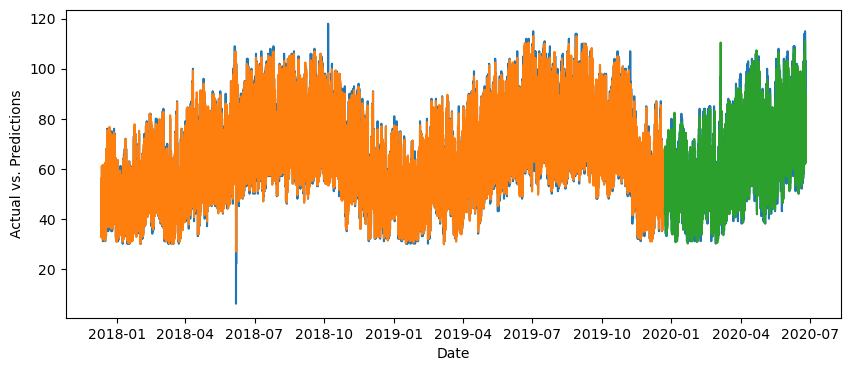

In [23]:
train_pred = train.copy()
train_pred['y_pred_train'] = y_pred_train

test_pred = test.copy()
test_pred['y_pred_test'] = y_pred_test
print([train_pred.shape, test_pred.shape])

actual_pred = pd.concat([train_pred, test_pred], axis=0)
actual_pred.shape

plt.figure(figsize=(10, 4))
plt.plot(actual_pred['date'], actual_pred[['y', 'y_pred_train', 'y_pred_test']])
plt.xlabel('Date')
plt.ylabel('Actual vs. Predictions')
plt.show()